<a href="https://colab.research.google.com/github/whbpt/GREMLIN_PYTORCH/blob/master/GREMLIN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GREMLIN_pytorch

This is a bare minimum version of GREMLIN (no gap removal, etc), intended for educational/demo purposes.  For the full version see [GREMLIN_TF_v2.1](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF.ipynb) 

In [0]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <so@g.harvard.edu> and <pkk382@g.harvard.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------

###reimplemented with pytorch by haobo wang, 20190323
# "THE APPLE CIDER LICENSE" :
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy me an apple cider in return.

## Load some libraries

In [0]:
import numpy as np
import matplotlib.pylab as plt
import torch

## Convert FASTA to MSA np.array()

In [0]:
def parse_fasta(filename):
  '''function to parse fasta file'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)

def one_hot(msa,states):
  one = np.eye(states)
  return one[msa]

def mk_msa(seqs):
  '''one hot encode msa'''
  
  ################
  alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)
  a2n = {}
  for a,n in zip(alphabet,range(states)):
    a2n[a] = n

  def aa2num(aa):
    '''convert aa into num'''
    if aa in a2n: return a2n[aa]
    else: return a2n['-']
  ################
  
  msa = []
  for seq in seqs:
    msa.append([aa2num(aa) for aa in seq])
  msa_ori = np.array(msa)
  return msa_ori, one_hot(msa_ori,states)

## load example

In [0]:
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [5]:
names,seqs = parse_fasta("4FAZA.fas")
msa_ori, msa = mk_msa(seqs)

print(msa_ori.shape)
print(msa.shape)

(817, 62)
(817, 62, 21)


In [21]:
import torch
import torch.nn.functional as F
#def GREMLIN_torch(msa, opt_iter=100,batch_size=100):
from torch.autograd import Variable

  
#enviroment setting
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU

# collecting some information about input msa
nrow = msa.shape[0] # number of sequences
ncol = msa.shape[1] # length of sequence
states = msa.shape[2] # number of states (or categories)


MSA_0 = torch.from_numpy(msa.astype(np.float32))
MSA = torch.reshape(MSA_0,(-1,ncol*states))

W = Variable(torch.zeros(ncol*states, ncol*states), requires_grad=True)
#W = torch.empty(ncol*states, ncol*states,requires_grad=True)
b = Variable(torch.zeros(ncol*states), requires_grad=True)

learning_rate = 5e-4

for t in range(100):

    MSA_pred = MSA.mm(W) + b
    MSA_pred = torch.reshape(MSA_pred,(-1,ncol,states))
    loss = torch.sum(- MSA_0 * F.log_softmax(MSA_pred, -1))
    loss = loss - 2 * torch.diagonal(W, 0).sum() + (W*W).sum()*ncol*states *0.01
    if (t) % (int(100/10)) == 0: 
      print(t, loss.item())
      
    loss.backward()
    with torch.no_grad():
        W -= learning_rate * W.grad
        b -= learning_rate * b.grad
        # Manually zero the gradients after updating weights
        W.grad.zero_()

0 154214.890625
10 49788.84765625
20 39611.4453125
30 35993.140625
40 34169.52734375
50 33162.265625
60 32573.849609375
70 32213.927734375
80 31981.5234375
90 31825.64453125


In [0]:
w = torch.Tensor.cpu(W).detach().numpy()
w = np.reshape(w,(ncol,states,ncol,states))

## get contacts

In [0]:
def get_mtx(W):
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W[:,:-1,:,:-1]),(1,3)))
  np.fill_diagonal(raw,0)
  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  return(raw,apc)

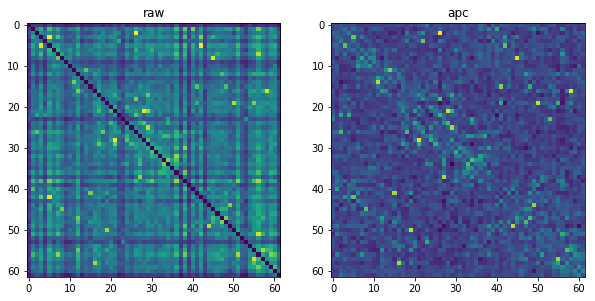

In [24]:
raw, apc = get_mtx(w)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.grid(False)
plt.title("raw")
plt.subplot(1,2,2)
plt.imshow(apc)
plt.grid(False)
plt.title("apc")
plt.show()